## Import needed Python Libraries

In [43]:
import os
import pandas as pd 
import numpy as np 
import matplotlib.pylab as plt 
import seaborn as sns 
from prophet import Prophet
from prophet.plot import plot_plotly
from prophet.diagnostics import cross_validation, performance_metrics
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

os.chdir ("C:\\Users\\junos\\OneDrive\\Documents\\Nexford\\BusinessModel")

print(os.getcwd())
plt.show()

#sns.set(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")

C:\Users\junos\OneDrive\Documents\Nexford\BusinessModel


In [44]:
#import the csv file into python
df = pd.read_csv("JayFitnessStore.csv")

In [45]:
df.head(3)

,Date,Store,Product_Category,Units_Sold,Price,Competitor_Price,Holiday_Flag,CPI,Campaign_Flag,Year,Month,Week,DayOfWeek,IsWeekend,Price_Diff,Discount_Flag
0,1/3/2023,Abuja,Fitness Gear,12,102522,97314,0,101.93,0,2024,3,13,6,1,5208,0
1,1/4/2023,Lagos,Supplements,6,122262,122262,0,100.85,0,2024,1,3,6,1,0,0
2,1/5/2023,Port Harcourt,Wellness Drinks,39,60858,66262,0,100.07,0,2023,2,7,6,1,-5404,1


In [46]:
df.tail(3)

,Date,Store,Product_Category,Units_Sold,Price,Competitor_Price,Holiday_Flag,CPI,Campaign_Flag,Year,Month,Week,DayOfWeek,IsWeekend,Price_Diff,Discount_Flag
1572,12/30/2024,Abuja,Supplements,5,30128,28560,0,104.99,1,2024,9,35,6,1,1568,0
1573,12/30/2024,Lagos,Wellness Drinks,11,39200,45318,1,104.94,0,2024,11,45,6,1,-6118,1
1574,12/31/2024,Port Harcourt,Fitness Gear,22,119280,111454,0,97.84,1,2023,1,2,6,1,7826,0


In [47]:
#checking the date type in the dataset
df.dtypes

Date                 object
Store                object
Product_Category     object
Units_Sold            int64
Price                 int64
Competitor_Price      int64
Holiday_Flag          int64
CPI                 float64
Campaign_Flag         int64
Year                  int64
Month                 int64
Week                  int64
DayOfWeek             int64
IsWeekend             int64
Price_Diff            int64
Discount_Flag         int64
dtype: object

In [48]:
# Address missing values in the dataset.
df.isnull()

,Date,Store,Product_Category,Units_Sold,Price,Competitor_Price,Holiday_Flag,CPI,Campaign_Flag,Year,Month,Week,DayOfWeek,IsWeekend,Price_Diff,Discount_Flag
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1570,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1571,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1572,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1573,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [49]:
# Total number of missing values in each columns of the data set
df.isnull().sum()
# Total sum of missing value in dataset
df.isnull().sum().sum()

0

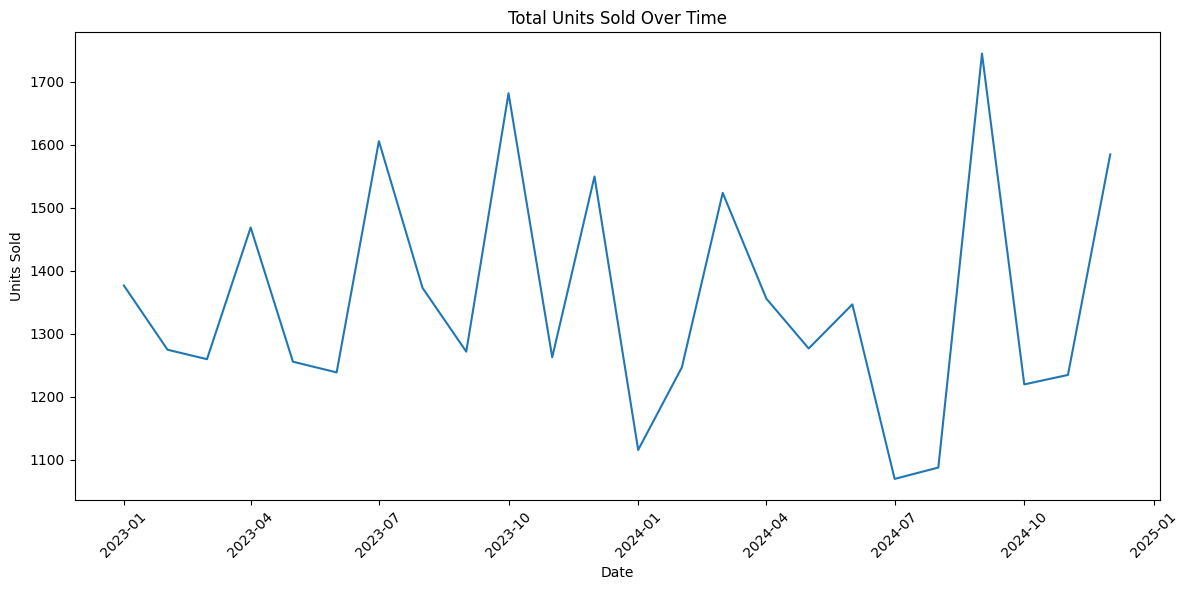

In [50]:
# Converting 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# monthly summary for analysis
monthly_summary = df.groupby(['Year', 'Month']).agg({
    'Units_Sold': 'sum',
    'Price': 'mean',
    'Competitor_Price': 'mean',
    'CPI': 'mean',
    'Campaign_Flag': 'sum',
    'Holiday_Flag': 'sum'
}).reset_index()

# Creating a new 'Month_Year' column for plotting
monthly_summary['Month_Year'] = pd.to_datetime(monthly_summary[['Year', 'Month']].assign(DAY=1))

# Plotting: Units Sold Over Time
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_summary, x='Month_Year', y='Units_Sold')
plt.title('Total Units Sold Over Time')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

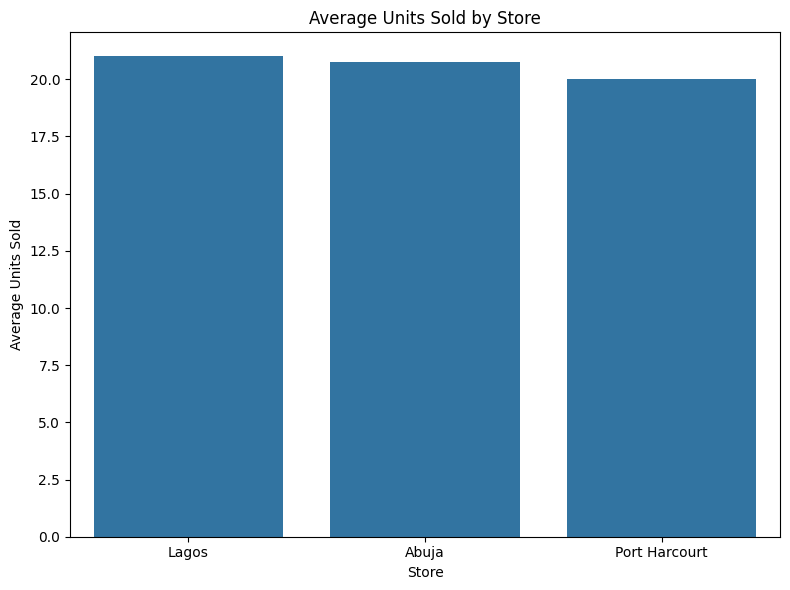

In [51]:
# Average Units Sold by Store
plt.figure(figsize=(8, 6))
store_avg = df.groupby('Store')['Units_Sold'].mean().sort_values(ascending=False)
sns.barplot(x=store_avg.index, y=store_avg.values)
plt.title('Average Units Sold by Store')
plt.ylabel('Average Units Sold')
plt.xlabel('Store')
plt.tight_layout()
plt.show()


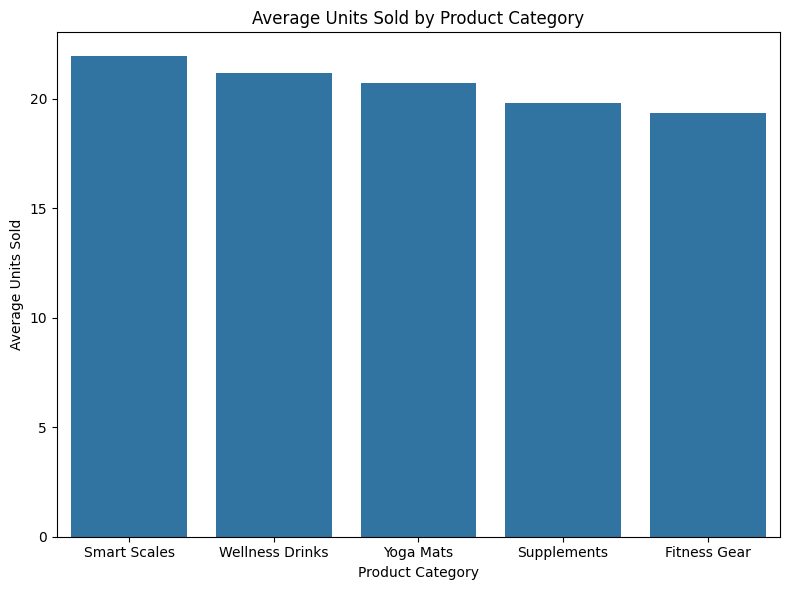

In [52]:
# Average Units Sold by Product Category
plt.figure(figsize=(8, 6))
category_avg = df.groupby('Product_Category')['Units_Sold'].mean().sort_values(ascending=False)
sns.barplot(x=category_avg.index, y=category_avg.values)
plt.title('Average Units Sold by Product Category')
plt.ylabel('Average Units Sold')
plt.xlabel('Product Category')
plt.tight_layout()
plt.show()


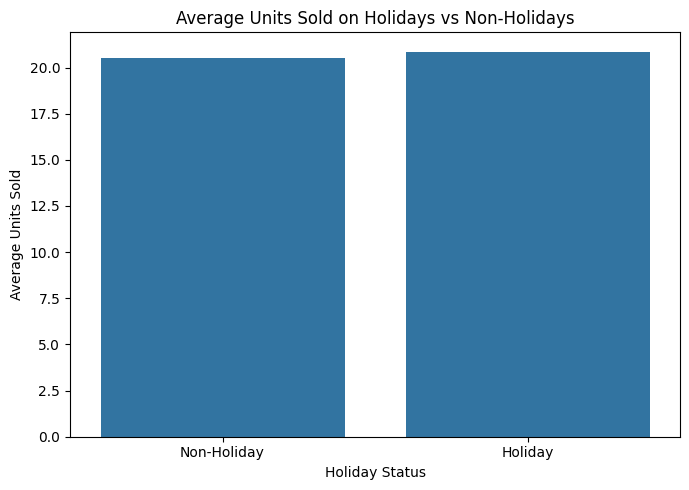

In [53]:
# Average Units Sold by Holiday Flag
plt.figure(figsize=(7, 5))
holiday_avg = df.groupby('Holiday_Flag')['Units_Sold'].mean()
sns.barplot(x=holiday_avg.index.map({0: 'Non-Holiday', 1: 'Holiday'}), y=holiday_avg.values)
plt.title('Average Units Sold on Holidays vs Non-Holidays')
plt.ylabel('Average Units Sold')
plt.xlabel('Holiday Status')
plt.tight_layout()
plt.show()


## Aggregate Monthly Demand

In [54]:
# Aggregate monthly data
df['Month'] = df['Date'].dt.to_period('M').dt.to_timestamp()
monthly_data = df.groupby('Month').agg({
    'Units_Sold': 'sum',
    'CPI': 'mean',
    'Campaign_Flag': 'sum',
    'Holiday_Flag': 'sum'
}).reset_index()
monthly_data.columns = ['ds', 'y', 'CPI', 'Campaigns', 'Holidays']
monthly_data.head()


,ds,y,CPI,Campaigns,Holidays
0,2023-01-01,1089,102.938772,16,9
1,2023-02-01,1314,102.527797,16,9
2,2023-03-01,1086,103.027679,16,8
3,2023-04-01,1415,102.533824,16,10
4,2023-05-01,1173,102.696949,20,7


# Forecasting Product Demand Using XGBoost (with External Factors)

In [55]:
# Aggregate monthly data
df['Month'] = df['Date'].dt.to_period('M').dt.to_timestamp()
monthly_data = df.groupby('Month').agg({
    'Units_Sold': 'sum',
    'CPI': 'mean',
    'Campaign_Flag': 'sum',
    'Holiday_Flag': 'sum'
}).reset_index()

monthly_data.columns = ['Date', 'Units_Sold', 'CPI', 'Campaigns', 'Holidays']

## Prepare Features and Train/Test Split

In [56]:
# Create lag features to mimic temporal effect
monthly_data['Lag_1'] = monthly_data['Units_Sold'].shift(1)
monthly_data = monthly_data.dropna()

# Define features and target
X = monthly_data[['CPI', 'Campaigns', 'Holidays', 'Lag_1']]
y = monthly_data['Units_Sold']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.25)


## Train XGBoost Model

In [57]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Predict
y_pred = xgb_model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"XGBoost MAE: {mae:.2f}")
print(f"XGBoost RMSE: {rmse:.2f}")

XGBoost MAE: 195.96
XGBoost RMSE: 222.52


## Actual vs Predicted Plot

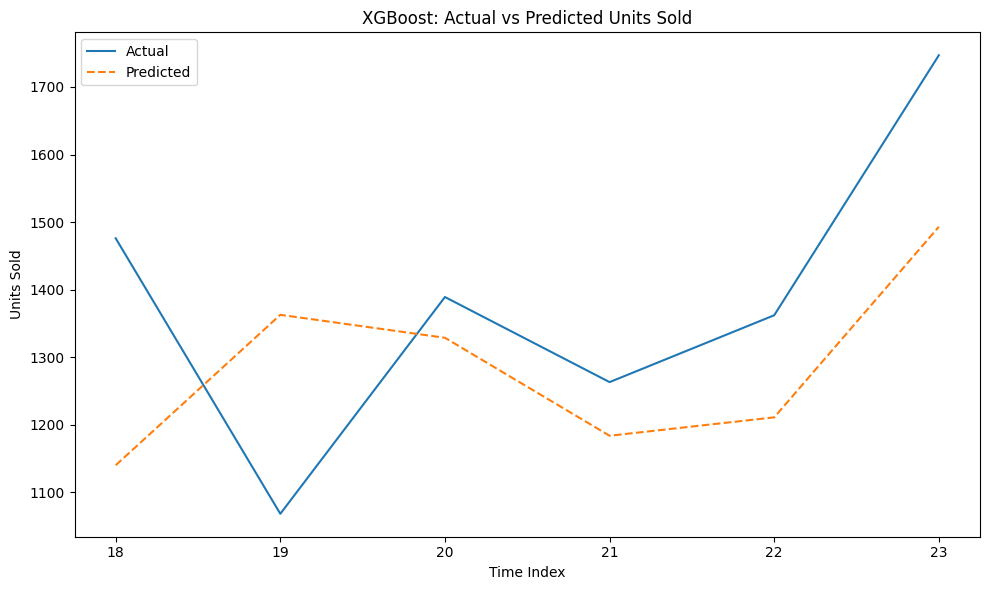

In [58]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted', linestyle='--')
plt.title('XGBoost: Actual vs Predicted Units Sold')
plt.xlabel('Time Index')
plt.ylabel('Units Sold')
plt.legend()
plt.tight_layout()
plt.show()

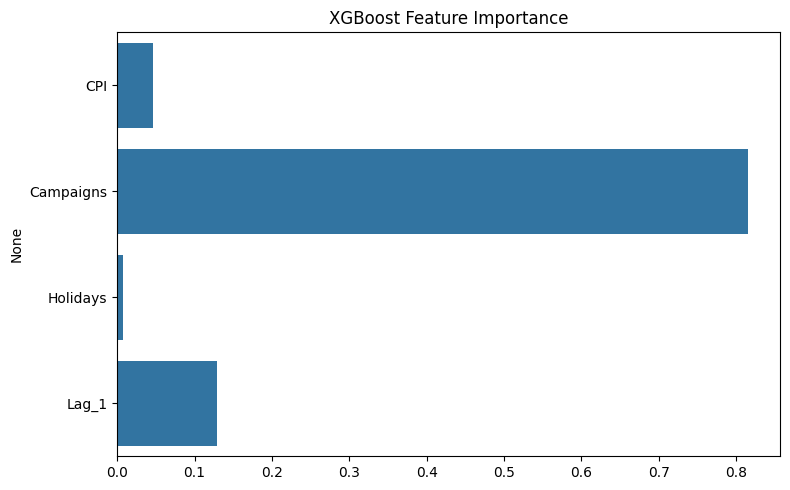

In [59]:
# Plot feature importance
plt.figure(figsize=(8, 5))
sns.barplot(x=xgb_model.feature_importances_, y=X.columns)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()